In [48]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV, KFold
from sklearn.feature_selection import f_regression, mutual_info_regression, f_classif
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve

In [3]:
pd.set_option('display.max_columns', None)

## Section 1 - Data Loading, Merging, Cleaning
- ### the first goal is to clean the original data frame this will involve merging the patient data onto the geographic data 
- ### we will also want to limit our feature set to simplify the data frame, removing columns that have already been encoded or columns that will cause leakage


### 1.1 - Loading Data 

In [4]:
#loads patient data
patient_data = pd.read_csv('../../../Data_Clean/RTED_ADIMERGE.csv')
geographic_data = pd.read_csv('../Data_Clean/geographic_data_clean.csv')

display(patient_data.head())

#drop state since it is already in the patient data frame
geographic_data = geographic_data.drop(labels = ['STATE'], axis = 1)

#encode ZIP_5 as a object for the merge on geographic data frame 
geographic_data['ZIP_5'] = geographic_data['ZIP_5'].astype(str)

#encode ZIP_5 as a object for merge on patient data frame
patient_data['ZIP_5'] = patient_data['ZIP_5'].astype(str)

#still some float values in there which we are causing data loss on the merge - grab first 5 characters of the string
patient_data['ZIP_5'] = patient_data['ZIP_5'].str[:5]

display(patient_data.head())
display(patient_data.info())
display(geographic_data.head())
display(geographic_data.info())


/var/folders/jc/0mjbccp53cqfmdh6hlys5sx40000gn/T/ipykernel_3946/1803228611.py:2: DtypeWarning: Columns (91) have mixed types. Specify dtype option on import or set low_memory=False.
  patient_data = pd.read_csv('../../../Data_Clean/RTED_ADIMERGE.csv')


,PAT_CLASS,PAT_BASE_CLASS,AGE,SEX,RACE,ETHNIC_GROUP,PAT_LANGUAGE,BMI,DX_HYPERTENSION,DX_RENAL_FAILURE,DX_COPD,DX_TYPE_2_DM,DX_HIP_FRACTURE,DX_OSTEOPOROSIS,PAT_ZIP,PAYOR_NAME,FINANCIAL_CLASS_NAME,DISCH_LOC_ABBR,DISCH_DEPT,LOS_DAYS,DISCHARGE_DISPO,ATTENDING_PROV,OR_LOGS,OR_LOG_ROW,CASE_CLASS_NM,LOCATION_ID,LOCATION_NM,LOCATION_NAME,SERVICE_NAME,PRIMARY_PHYSICIAN_NM,CLIN_DEP,CLIN_DIV,PRIMARY_PROCEDURE_NM,PRIMARY_PROC_CPT_CODE,PRIMARY_PROCEDURE_CPT,RET_CSN,RET_DAYS,RET_HOSPITAL,RET_ED_DISPO,RET_CHIEF_COMPLAINT,RET_CLINICAL_IMPRESSION,RET_HB_PRIM_DX_CODE,RET_HB_PRIM_DX_NAME,RET_ED30_NUMER,RET_ED_DENOM,EDRevisitDischargedPatient,READMISSION,FinancialClass_Commercial,FinancialClass_Liability,FinancialClass_ManagedCare,FinancialClass_MedicaidPending,FinancialClass_MediCARE,FinancialClass_MedicareAdvantage,FinancialClass_CommercialBlueCross,FinancialClass_MedicaidNC,FinancialClass_MedicaidManaged,FinancialClass_CommercialBCOOS,FinancialClass_Medcaid,FinancialClass_12Unkonwn,FinancialClass_13,FinancialClass_14,FinancialClass_15,FinancialClass_WorkersComp,MedicaidBinary,RaceDummy_4,RaceDummy_5,Hispanic_1,Hispanic_2,Hispanic_3,Hispanic_4,Hispanic_5,Hispanic_NotHispanic,Hispanic_7,Race_NotValid,Race_AmericanIndian,Race_Asian,Race_Black,Race_White,Race_NativeHawaiian,Race_NotReported,Race_Other,Race_OtherAsian,WhiteNonHipanic,ED90Day,Readmission90,EDRevisit90,Sex_Female,Sex_2,Sex_3,SevereObesity,Elderly65,ZIP_5,COUNTY,CITY,STATE,WEIGHTED_ADI
0,Inpatient,Inpatient,41.0,Male,Black or African American,Not Hispanic/Latino,English,23.83,0.0,0.0,0.0,0.0,0.0,0.0,27591,NaN,Self-Pay,DRAH,DRAH NP 3200N,4.0,Home or Self Care,"CHUANG, ELISEU YUNG",1.0,1.0,Level 3,10703005.0,DRAH OR,DRAH,Orthopedics,"REEG, SCOT ERIC",ORTHOPAEDICS-PDC,SPINE,"INCISION AND DRAINAGE OF ABSCESS, HAND/WRIST/F...",10061.0,PR I&D ABSC CMPLX/MULT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,27591,37101.0,WENDELL,NC,53.161370
1,Inpatient,Inpatient,77.0,Male,Caucasian/White,Not Hispanic/Latino,English,28.58,1.0,0.0,0.0,0.0,0.0,1.0,27614,MEDICARE,Medicare,DRAH,DRAH NP 4200,10.9,Skilled Nursing Facility,"GOPAL, VANITHA ANDAL",1.0,1.0,Level 5,10703005.0,DRAH OR,DRAH,Orthopedics,"REEG, SCOT ERIC",ORTHOPAEDICS-PDC,SPINE,"PERCU VERTEBRAL AUGMENTATION, THORACIC, INCLUD...",22513.0,PR PERQ VERT AGMNTJ CAVITY CRTJ UNI/BI CANNULA...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,27614,37183.0,RALEIGH,NC,23.760328
2,Inpatient,Inpatient,66.0,Female,Black or African American,Not Hispanic/Latino,English,27.12,1.0,1.0,0.0,1.0,0.0,0.0,27589-9587,AETNA MEDICARE ADVANTAGE,Medicare Advantage,DRAH,DRAH SP 3700,32.5,Home Health Service,"AMOO, AKUA ADWUBI PANYIN",1.0,1.0,Elective,10703005.0,DRAH OR,DRAH,Orthopedics,"REEG, SCOT ERIC",ORTHOPAEDICS-PDC,SPINE,"ARTHRODESIS, ANTERIOR INTERBODY, INCLUDING DIS...",22551.0,"PR ARTHRODESIS ANT INTERBODY INC DISCECTOMY, C...",291089590.0,24.73,DUH,ADMIT,ALTERED MENTAL STATUS,"Altered mental status, unspecified altered men...",K76.82,Hepatic encephalopathy,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,27589,37069.0,WARRENTON,NC,90.847199
3,Inpatient,Inpatient,50.0,Female,Asian,Not Hispanic/Latino,Burmese,22.29,0.0,0.0,0.0,0.0,0.0,0.0,28334,UHC COMMUNITY PLAN NC,NC Medicaid Managed Care,DRAH,DRAH NP 2200N,16.6,Skilled Nursing Facility,"DORR, VICTORIA JOAN",1.0,1.0,Elective,10703005.0,DRAH OR,DRAH,Orthopedics,"REEG, SCOT ERIC",ORTHOPAEDICS-PDC,SPINE,POSTERIOR CERVICAL SPINE FUSION 2 interspace,22614.0,PR ARTHRODESIS PST/PSTLAT TQ 1NTRSPC EA ADDL N...,260620011.0,39.86,DRAH,

,PAT_CLASS,PAT_BASE_CLASS,AGE,SEX,RACE,ETHNIC_GROUP,PAT_LANGUAGE,BMI,DX_HYPERTENSION,DX_RENAL_FAILURE,DX_COPD,DX_TYPE_2_DM,DX_HIP_FRACTURE,DX_OSTEOPOROSIS,PAT_ZIP,PAYOR_NAME,FINANCIAL_CLASS_NAME,DISCH_LOC_ABBR,DISCH_DEPT,LOS_DAYS,DISCHARGE_DISPO,ATTENDING_PROV,OR_LOGS,OR_LOG_ROW,CASE_CLASS_NM,LOCATION_ID,LOCATION_NM,LOCATION_NAME,SERVICE_NAME,PRIMARY_PHYSICIAN_NM,CLIN_DEP,CLIN_DIV,PRIMARY_PROCEDURE_NM,PRIMARY_PROC_CPT_CODE,PRIMARY_PROCEDURE_CPT,RET_CSN,RET_DAYS,RET_HOSPITAL,RET_ED_DISPO,RET_CHIEF_COMPLAINT,RET_CLINICAL_IMPRESSION,RET_HB_PRIM_DX_CODE,RET_HB_PRIM_DX_NAME,RET_ED30_NUMER,RET_ED_DENOM,EDRevisitDischargedPatient,READMISSION,FinancialClass_Commercial,FinancialClass_Liability,FinancialClass_ManagedCare,FinancialClass_MedicaidPending,FinancialClass_MediCARE,FinancialClass_MedicareAdvantage,FinancialClass_CommercialBlueCross,FinancialClass_MedicaidNC,FinancialClass_MedicaidManaged,FinancialClass_CommercialBCOOS,FinancialClass_Medcaid,FinancialClass_12Unkonwn,FinancialClass_13,FinancialClass_14,FinancialClass_15,FinancialClass_WorkersComp,MedicaidBinary,RaceDummy_4,RaceDummy_5,Hispanic_1,Hispanic_2,Hispanic_3,Hispanic_4,Hispanic_5,Hispanic_NotHispanic,Hispanic_7,Race_NotValid,Race_AmericanIndian,Race_Asian,Race_Black,Race_White,Race_NativeHawaiian,Race_NotReported,Race_Other,Race_OtherAsian,WhiteNonHipanic,ED90Day,Readmission90,EDRevisit90,Sex_Female,Sex_2,Sex_3,SevereObesity,Elderly65,ZIP_5,COUNTY,CITY,STATE,WEIGHTED_ADI
0,Inpatient,Inpatient,41.0,Male,Black or African American,Not Hispanic/Latino,English,23.83,0.0,0.0,0.0,0.0,0.0,0.0,27591,NaN,Self-Pay,DRAH,DRAH NP 3200N,4.0,Home or Self Care,"CHUANG, ELISEU YUNG",1.0,1.0,Level 3,10703005.0,DRAH OR,DRAH,Orthopedics,"REEG, SCOT ERIC",ORTHOPAEDICS-PDC,SPINE,"INCISION AND DRAINAGE OF ABSCESS, HAND/WRIST/F...",10061.0,PR I&D ABSC CMPLX/MULT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,27591,37101.0,WENDELL,NC,53.161370
1,Inpatient,Inpatient,77.0,Male,Caucasian/White,Not Hispanic/Latino,English,28.58,1.0,0.0,0.0,0.0,0.0,1.0,27614,MEDICARE,Medicare,DRAH,DRAH NP 4200,10.9,Skilled Nursing Facility,"GOPAL, VANITHA ANDAL",1.0,1.0,Level 5,10703005.0,DRAH OR,DRAH,Orthopedics,"REEG, SCOT ERIC",ORTHOPAEDICS-PDC,SPINE,"PERCU VERTEBRAL AUGMENTATION, THORACIC, INCLUD...",22513.0,PR PERQ VERT AGMNTJ CAVITY CRTJ UNI/BI CANNULA...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,27614,37183.0,RALEIGH,NC,23.760328
2,Inpatient,Inpatient,66.0,Female,Black or African American,Not Hispanic/Latino,English,27.12,1.0,1.0,0.0,1.0,0.0,0.0,27589-9587,AETNA MEDICARE ADVANTAGE,Medicare Advantage,DRAH,DRAH SP 3700,32.5,Home Health Service,"AMOO, AKUA ADWUBI PANYIN",1.0,1.0,Elective,10703005.0,DRAH OR,DRAH,Orthopedics,"REEG, SCOT ERIC",ORTHOPAEDICS-PDC,SPINE,"ARTHRODESIS, ANTERIOR INTERBODY, INCLUDING DIS...",22551.0,"PR ARTHRODESIS ANT INTERBODY INC DISCECTOMY, C...",291089590.0,24.73,DUH,ADMIT,ALTERED MENTAL STATUS,"Altered mental status, unspecified altered men...",K76.82,Hepatic encephalopathy,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,27589,37069.0,WARRENTON,NC,90.847199
3,Inpatient,Inpatient,50.0,Female,Asian,Not Hispanic/Latino,Burmese,22.29,0.0,0.0,0.0,0.0,0.0,0.0,28334,UHC COMMUNITY PLAN NC,NC Medicaid Managed Care,DRAH,DRAH NP 2200N,16.6,Skilled Nursing Facility,"DORR, VICTORIA JOAN",1.0,1.0,Elective,10703005.0,DRAH OR,DRAH,Orthopedics,"REEG, SCOT ERIC",ORTHOPAEDICS-PDC,SPINE,POSTERIOR CERVICAL SPINE FUSION 2 interspace,22614.0,PR ARTHRODESIS PST/PSTLAT TQ 1NTRSPC EA ADDL N...,260620011.0,39.86,DRAH,

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26535 entries, 0 to 26534
Data columns (total 96 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   PAT_CLASS                           26535 non-null  object 
 1   PAT_BASE_CLASS                      26535 non-null  object 
 2   AGE                                 26535 non-null  float64
 3   SEX                                 26535 non-null  object 
 4   RACE                                26532 non-null  object 
 5   ETHNIC_GROUP                        26532 non-null  object 
 6   PAT_LANGUAGE                        26535 non-null  object 
 7   BMI                                 23651 non-null  float64
 8   DX_HYPERTENSION                     26515 non-null  float64
 9   DX_RENAL_FAILURE                    26515 non-null  float64
 10  DX_COPD                             26515 non-null  float64
 11  DX_TYPE_2_DM                        26515

None

,ZIP_5,location,Latitude,Longitude,distance_to_hospital
0,99507,"Anchorage, AK 99507, USA",61.148769,-149.801081,3454.199763
1,99577,"Eagle River, AK 99577, USA",61.267364,-149.289167,3436.686174
2,94123,"San Francisco, CA 94123, USA",37.802040,-122.438231,2384.803170
3,97448,"Junction City, OR 97448, USA",44.218895,-123.314505,2381.982656
4,98632,"Longview, WA 98632, USA",46.138159,-122.938164,2362.964944


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1523 entries, 0 to 1522
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ZIP_5                 1523 non-null   object 
 1   location              1523 non-null   object 
 2   Latitude              1523 non-null   float64
 3   Longitude             1523 non-null   float64
 4   distance_to_hospital  1523 non-null   float64
dtypes: float64(3), object(2)
memory usage: 59.6+ KB


None

### 1.2 - Merging Data
- #### we see that we have 1523 unique zip codes and with distance information and a total of 26515 patient observations 
- #### lets merge our data now and see if we have any informaiton loss 


In [5]:
#merged geographic and patient data frame
def merge_data(df1, df2): 

    #merge lat/lon
    merged_data = pd.merge(df1, df2, how = 'left', on = 'ZIP_5')

    return merged_data 

df_full = merge_data(patient_data, geographic_data)

#we still have almost all the distance data for our patients!
display(df_full.head())
display(df_full.info())


,PAT_CLASS,PAT_BASE_CLASS,AGE,SEX,RACE,ETHNIC_GROUP,PAT_LANGUAGE,BMI,DX_HYPERTENSION,DX_RENAL_FAILURE,DX_COPD,DX_TYPE_2_DM,DX_HIP_FRACTURE,DX_OSTEOPOROSIS,PAT_ZIP,PAYOR_NAME,FINANCIAL_CLASS_NAME,DISCH_LOC_ABBR,DISCH_DEPT,LOS_DAYS,DISCHARGE_DISPO,ATTENDING_PROV,OR_LOGS,OR_LOG_ROW,CASE_CLASS_NM,LOCATION_ID,LOCATION_NM,LOCATION_NAME,SERVICE_NAME,PRIMARY_PHYSICIAN_NM,CLIN_DEP,CLIN_DIV,PRIMARY_PROCEDURE_NM,PRIMARY_PROC_CPT_CODE,PRIMARY_PROCEDURE_CPT,RET_CSN,RET_DAYS,RET_HOSPITAL,RET_ED_DISPO,RET_CHIEF_COMPLAINT,RET_CLINICAL_IMPRESSION,RET_HB_PRIM_DX_CODE,RET_HB_PRIM_DX_NAME,RET_ED30_NUMER,RET_ED_DENOM,EDRevisitDischargedPatient,READMISSION,FinancialClass_Commercial,FinancialClass_Liability,FinancialClass_ManagedCare,FinancialClass_MedicaidPending,FinancialClass_MediCARE,FinancialClass_MedicareAdvantage,FinancialClass_CommercialBlueCross,FinancialClass_MedicaidNC,FinancialClass_MedicaidManaged,FinancialClass_CommercialBCOOS,FinancialClass_Medcaid,FinancialClass_12Unkonwn,FinancialClass_13,FinancialClass_14,FinancialClass_15,FinancialClass_WorkersComp,MedicaidBinary,RaceDummy_4,RaceDummy_5,Hispanic_1,Hispanic_2,Hispanic_3,Hispanic_4,Hispanic_5,Hispanic_NotHispanic,Hispanic_7,Race_NotValid,Race_AmericanIndian,Race_Asian,Race_Black,Race_White,Race_NativeHawaiian,Race_NotReported,Race_Other,Race_OtherAsian,WhiteNonHipanic,ED90Day,Readmission90,EDRevisit90,Sex_Female,Sex_2,Sex_3,SevereObesity,Elderly65,ZIP_5,COUNTY,CITY,STATE,WEIGHTED_ADI,location,Latitude,Longitude,distance_to_hospital
0,Inpatient,Inpatient,41.0,Male,Black or African American,Not Hispanic/Latino,English,23.83,0.0,0.0,0.0,0.0,0.0,0.0,27591,NaN,Self-Pay,DRAH,DRAH NP 3200N,4.0,Home or Self Care,"CHUANG, ELISEU YUNG",1.0,1.0,Level 3,10703005.0,DRAH OR,DRAH,Orthopedics,"REEG, SCOT ERIC",ORTHOPAEDICS-PDC,SPINE,"INCISION AND DRAINAGE OF ABSCESS, HAND/WRIST/F...",10061.0,PR I&D ABSC CMPLX/MULT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,27591,37101.0,WENDELL,NC,53.161370,"Eagle Rock, NC 27591, USA",35.761843,-78.361467,36.432272
1,Inpatient,Inpatient,77.0,Male,Caucasian/White,Not Hispanic/Latino,English,28.58,1.0,0.0,0.0,0.0,0.0,1.0,27614,MEDICARE,Medicare,DRAH,DRAH NP 4200,10.9,Skilled Nursing Facility,"GOPAL, VANITHA ANDAL",1.0,1.0,Level 5,10703005.0,DRAH OR,DRAH,Orthopedics,"REEG, SCOT ERIC",ORTHOPAEDICS-PDC,SPINE,"PERCU VERTEBRAL AUGMENTATION, THORACIC, INCLUD...",22513.0,PR PERQ VERT AGMNTJ CAVITY CRTJ UNI/BI CANNULA...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,27614,37183.0,RALEIGH,NC,23.760328,"Raleigh, NC 27614, USA",35.948496,-78.622850,18.058521
2,Inpatient,Inpatient,66.0,Female,Black or African American,Not Hispanic/Latino,English,27.12,1.0,1.0,0.0,1.0,0.0,0.0,27589-9587,AETNA MEDICARE ADVANTAGE,Medicare Advantage,DRAH,DRAH SP 3700,32.5,Home Health Service,"AMOO, AKUA ADWUBI PANYIN",1.0,1.0,Elective,10703005.0,DRAH OR,DRAH,Orthopedics,"REEG, SCOT ERIC",ORTHOPAEDICS-PDC,SPINE,"ARTHRODESIS, ANTERIOR INTERBODY, INCLUDING DIS...",22551.0,"PR ARTHRODESIS ANT INTERBODY INC DISCECTOMY, C...",291089590.0,24.73,DUH,ADMIT,ALTERED MENTAL STATUS,"Altered mental status, unspecified altered men...",K76.82,Hepatic encephalopathy,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,27589,37069.0,WARRENTON,NC,90.847199,"Warrenton, NC 27589, USA",36.320878,-78.156443,48.669063
3,Inpatient,Inpatient,50.0,Female,Asian,Not Hispanic/Latino,Burmese,22.29,0.0,0.0,0.0,0.0,0.0,0.0,28334,UHC COMMUNITY PLAN NC,NC Medicaid Managed Care,DRAH,DRAH NP 2200N,16.6,Skilled Nursing Facility,"DORR, VICTORIA JOAN

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26535 entries, 0 to 26534
Data columns (total 100 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   PAT_CLASS                           26535 non-null  object 
 1   PAT_BASE_CLASS                      26535 non-null  object 
 2   AGE                                 26535 non-null  float64
 3   SEX                                 26535 non-null  object 
 4   RACE                                26532 non-null  object 
 5   ETHNIC_GROUP                        26532 non-null  object 
 6   PAT_LANGUAGE                        26535 non-null  object 
 7   BMI                                 23651 non-null  float64
 8   DX_HYPERTENSION                     26515 non-null  float64
 9   DX_RENAL_FAILURE                    26515 non-null  float64
 10  DX_COPD                             26515 non-null  float64
 11  DX_TYPE_2_DM                        2651

None

### 1.3 Simplify Columns 
- #### we have 3454 total patients in our data set, we geographic and ADI data 3431 of them 
- #### we have many columns that we will not use, in our first try lets drop all geographic data besides ADI and distance from hospital, all RET descriptors and other potential predictors
    - ##### Rational: 
     - payor name: already using financial class
     - attending provider: do not want to evaluate physician performance
     -  OR logs/log row: I think this is clerical documentation (ask), 
     - Location Name/Location_NM: Only need one variable that refers to location - keeping ID, 
     - CLIN_DEP: all OT patients 
     - PRIMARY_PROCEDURE_NM: keeping PRIMARY_PROCEDURE_CPT_CODE only need one 
     - PRIMARY_PROCEDURE_CPT: keeping PRIMARY_PROCEDURE_CPT_CODE
     


In [6]:
#columns that will clearly cause leakage
cols_leakage = ['RET_CSN', 'RET_DAYS', 'RET_HOSPITAL', 'RET_ED_DISPO', 'RET_CHIEF_COMPLAINT', 
                'RET_CLINICAL_IMPRESSION', 'RET_HB_PRIM_DX_CODE', 'RET_HB_PRIM_DX_NAME', 'RET_ED_DENOM',
                'RET_ED30_NUMER', 'EDRevisitDischargedPatient', 'READMISSION', 'Readmission90', 'EDRevisit90']

display(len(cols_leakage))

#geographic columns we used to get distance from hospital and state (what we will use in model)
cols_geodrop = ['PAT_ZIP', 'COUNTY', 'CITY', 'location', 'Latitude', 'Longitude', 'WEIGHTED_ADI']

display(len(cols_geodrop))

#other columns we will drop for now, can keep some potentially for deep learning
cols_other_drop = ['PAYOR_NAME', 'ATTENDING_PROV', 'OR_LOGS', 'OR_LOG_ROW', 'LOCATION_NAME', 
                   'LOCATION_NM', 'SERVICE_NAME', 'PRIMARY_PHYSICIAN_NM', 'CLIN_DEP', 
                   'PRIMARY_PROCEDURE_NM', 'PRIMARY_PROCEDURE_CPT']

display(len(cols_other_drop))

14

7

11

In [7]:
def drop_cols(df): 
    df_leak_dropped = df.drop(labels = cols_leakage, axis = 1)
    df_geo_dropped = df_leak_dropped.drop(labels = cols_geodrop, axis =1 )
    df_dropped = df_geo_dropped.drop(labels = cols_other_drop, axis = 1)

    return df_dropped

df_simplified = drop_cols(df_full)
df_simplified.info()
df_simplified.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26535 entries, 0 to 26534
Data columns (total 68 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   PAT_CLASS                           26535 non-null  object 
 1   PAT_BASE_CLASS                      26535 non-null  object 
 2   AGE                                 26535 non-null  float64
 3   SEX                                 26535 non-null  object 
 4   RACE                                26532 non-null  object 
 5   ETHNIC_GROUP                        26532 non-null  object 
 6   PAT_LANGUAGE                        26535 non-null  object 
 7   BMI                                 23651 non-null  float64
 8   DX_HYPERTENSION                     26515 non-null  float64
 9   DX_RENAL_FAILURE                    26515 non-null  float64
 10  DX_COPD                             26515 non-null  float64
 11  DX_TYPE_2_DM                        26515

,PAT_CLASS,PAT_BASE_CLASS,AGE,SEX,RACE,ETHNIC_GROUP,PAT_LANGUAGE,BMI,DX_HYPERTENSION,DX_RENAL_FAILURE,DX_COPD,DX_TYPE_2_DM,DX_HIP_FRACTURE,DX_OSTEOPOROSIS,FINANCIAL_CLASS_NAME,DISCH_LOC_ABBR,DISCH_DEPT,LOS_DAYS,DISCHARGE_DISPO,CASE_CLASS_NM,LOCATION_ID,CLIN_DIV,PRIMARY_PROC_CPT_CODE,FinancialClass_Commercial,FinancialClass_Liability,FinancialClass_ManagedCare,FinancialClass_MedicaidPending,FinancialClass_MediCARE,FinancialClass_MedicareAdvantage,FinancialClass_CommercialBlueCross,FinancialClass_MedicaidNC,FinancialClass_MedicaidManaged,FinancialClass_CommercialBCOOS,FinancialClass_Medcaid,FinancialClass_12Unkonwn,FinancialClass_13,FinancialClass_14,FinancialClass_15,FinancialClass_WorkersComp,MedicaidBinary,RaceDummy_4,RaceDummy_5,Hispanic_1,Hispanic_2,Hispanic_3,Hispanic_4,Hispanic_5,Hispanic_NotHispanic,Hispanic_7,Race_NotValid,Race_AmericanIndian,Race_Asian,Race_Black,Race_White,Race_NativeHawaiian,Race_NotReported,Race_Other,Race_OtherAsian,WhiteNonHipanic,ED90Day,Sex_Female,Sex_2,Sex_3,SevereObesity,Elderly65,ZIP_5,STATE,distance_to_hospital
0,Inpatient,Inpatient,41.0,Male,Black or African American,Not Hispanic/Latino,English,23.83,0.0,0.0,0.0,0.0,0.0,0.0,Self-Pay,DRAH,DRAH NP 3200N,4.0,Home or Self Care,Level 3,10703005.0,SPINE,10061.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,27591,NC,36.432272
1,Inpatient,Inpatient,77.0,Male,Caucasian/White,Not Hispanic/Latino,English,28.58,1.0,0.0,0.0,0.0,0.0,1.0,Medicare,DRAH,DRAH NP 4200,10.9,Skilled Nursing Facility,Level 5,10703005.0,SPINE,22513.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,27614,NC,18.058521
2,Inpatient,Inpatient,66.0,Female,Black or African American,Not Hispanic/Latino,English,27.12,1.0,1.0,0.0,1.0,0.0,0.0,Medicare Advantage,DRAH,DRAH SP 3700,32.5,Home Health Service,Elective,10703005.0,SPINE,22551.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,27589,NC,48.669063
3,Inpatient,Inpatient,50.0,Female,Asian,Not Hispanic/Latino,Burmese,22.29,0.0,0.0,0.0,0.0,0.0,0.0,NC Medicaid Managed Care,DRAH,DRAH NP 2200N,16.6,Skilled Nursing Facility,Elective,10703005.0,SPINE,22614.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,28334,NC,58.136057
4,Inpatient,Inpatient,44.0,Male,Black or African American,Not Hispanic/Latino,English,19.11,1.0,0.0,0.0,0.0,0.0,0.0,Medicare Advantage,DRAH,DRAH SP 3700,8.1,Skilled Nursing Facility,Level 5,10703005.0,SPINE,22850.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,27889,NC,110.376278


### 1.4 Address Missingness 
- #### For columns with less than 10 observations missing we can drop the observtions (rule of thumb <5%)
- #### For BMI and Distance to hospital we may have to impute the values 

In [8]:
#drop na for columns with minimal na values
cols_dropna = ['RACE', 'ETHNIC_GROUP', 'DX_HYPERTENSION', 'DX_RENAL_FAILURE', 'DX_COPD', 'DX_TYPE_2_DM', 'DX_HIP_FRACTURE', 'DX_OSTEOPOROSIS', 'STATE', 'PRIMARY_PROC_CPT_CODE']

cols_fillna = ['BMI', 'distance_to_hospital']

def handle_missingness(df, colsdrop, collsfill): 

    #drop na for columns with only a few missing values 
    df_clean = df.dropna(subset = colsdrop, axis = 0)

    #fill BMI and distance with the median due to right tailed distribution (will handle outliers later)  
    df_clean[collsfill] = df_clean[collsfill].fillna(df_clean[collsfill].median())

    return df_clean

df_clean = handle_missingness(df_simplified, cols_dropna, cols_fillna)

#now our data has no missing values and we are ready to split into train and test set
display(df_clean.isna().sum())
df_clean.info()

/var/folders/jc/0mjbccp53cqfmdh6hlys5sx40000gn/T/ipykernel_3946/4213555685.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[collsfill] = df_clean[collsfill].fillna(df_clean[collsfill].median())


PAT_CLASS               0
PAT_BASE_CLASS          0
AGE                     0
SEX                     0
RACE                    0
                       ..
SevereObesity           0
Elderly65               0
ZIP_5                   0
STATE                   0
distance_to_hospital    0
Length: 68, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26453 entries, 0 to 26534
Data columns (total 68 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   PAT_CLASS                           26453 non-null  object 
 1   PAT_BASE_CLASS                      26453 non-null  object 
 2   AGE                                 26453 non-null  float64
 3   SEX                                 26453 non-null  object 
 4   RACE                                26453 non-null  object 
 5   ETHNIC_GROUP                        26453 non-null  object 
 6   PAT_LANGUAGE                        26453 non-null  object 
 7   BMI                                 26453 non-null  float64
 8   DX_HYPERTENSION                     26453 non-null  float64
 9   DX_RENAL_FAILURE                    26453 non-null  float64
 10  DX_COPD                             26453 non-null  float64
 11  DX_TYPE_2_DM                        26453

### 1.5 Visualize Numerical Variables and drop outliers 

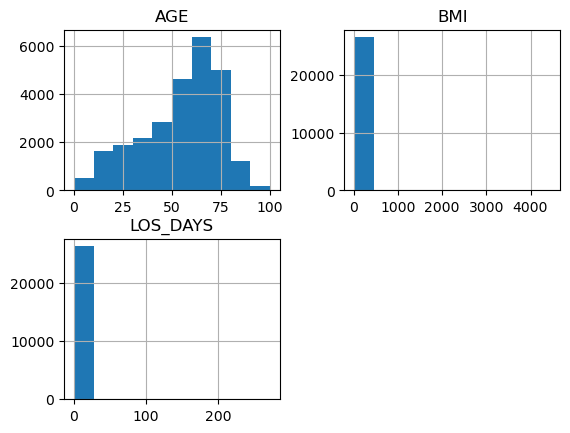

In [9]:
#handle outliers of numerical variables 
num_cols = ['AGE', 'BMI', 'LOS_DAYS']

def plot_numerical(df, cols): 
    df[cols].hist()
    plt.show()
    return df 

#based on these plots I want to drop BMI outliers, I will keep age as is, and I want to investigate LOS more closely
df_clean = plot_numerical(df_clean, num_cols)

In [10]:
#This is a very skewed distriubution. Given we are predicting 90 day ED return lets drop all LOS > 90 
df_clean.sort_values(by = 'LOS_DAYS', axis = 0, ascending = False)

,PAT_CLASS,PAT_BASE_CLASS,AGE,SEX,RACE,ETHNIC_GROUP,PAT_LANGUAGE,BMI,DX_HYPERTENSION,DX_RENAL_FAILURE,DX_COPD,DX_TYPE_2_DM,DX_HIP_FRACTURE,DX_OSTEOPOROSIS,FINANCIAL_CLASS_NAME,DISCH_LOC_ABBR,DISCH_DEPT,LOS_DAYS,DISCHARGE_DISPO,CASE_CLASS_NM,LOCATION_ID,CLIN_DIV,PRIMARY_PROC_CPT_CODE,FinancialClass_Commercial,FinancialClass_Liability,FinancialClass_ManagedCare,FinancialClass_MedicaidPending,FinancialClass_MediCARE,FinancialClass_MedicareAdvantage,FinancialClass_CommercialBlueCross,FinancialClass_MedicaidNC,FinancialClass_MedicaidManaged,FinancialClass_CommercialBCOOS,FinancialClass_Medcaid,FinancialClass_12Unkonwn,FinancialClass_13,FinancialClass_14,FinancialClass_15,FinancialClass_WorkersComp,MedicaidBinary,RaceDummy_4,RaceDummy_5,Hispanic_1,Hispanic_2,Hispanic_3,Hispanic_4,Hispanic_5,Hispanic_NotHispanic,Hispanic_7,Race_NotValid,Race_AmericanIndian,Race_Asian,Race_Black,Race_White,Race_NativeHawaiian,Race_NotReported,Race_Other,Race_OtherAsian,WhiteNonHipanic,ED90Day,Sex_Female,Sex_2,Sex_3,SevereObesity,Elderly65,ZIP_5,STATE,distance_to_hospital
8909,Inpatient,Inpatient,19.0,Male,Black or African American,Not Hispanic/Latino,English,22.08,1.0,1.0,0.0,0.0,0.0,0.0,NC MEDICAID,DUH,DUH N2100 GENERAL SURGERY,271.6,Skilled Nursing Facility,Elective,10703000.0,TRAUMA,11012.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,27705,NC,2.960743
7833,Inpatient,Inpatient,52.0,Male,Caucasian/White,Not Hispanic/Latino,English,19.77,1.0,1.0,0.0,0.0,0.0,0.0,NC MEDICAID,DUH,DCT 6A/6B SOLID ORGAN TRANSPLANT,265.9,Skilled Nursing Facility,Elective,10703000.0,TRAUMA,26990.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,27258,NC,21.913084
8286,Inpatient,Inpatient,66.0,Male,Black or African American,Not Hispanic/Latino,English,26.16,1.0,0.0,1.0,1.0,0.0,0.0,Medicare,DUH,DUH N3300 GENERAL/THORACIC/CARDIOTHORACIC SURGERY,210.0,Skilled Nursing Facility,Elective,10703000.0,TRAUMA,27610.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,27703,NC,7.983303
9334,Inpatient,Inpatient,66.0,Male,Caucasian/White,Not Hispanic/Latino,English,20.59,1.0,1.0,0.0,0.0,1.0,0.0,Medicare Advantage,DUH,DUH N7300 CARDIOLOGY,170.2,Hospice Medical Inpatient,Elective,10703000.0,TRAUMA,27125.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,27563,NC,51.308262
25903,Inpatient,Inpatient,39.0,Male,Black or African American,Not Hispanic/Latino,English,28.76,1.0,0.0,0.0,0.0,0.0,0.0,Medicaid Pending,DUH,DCT 8A/8B NEUROSCIENCE STEPDOWN,153.6,Skilled Nursing Facility,Level 5,10703000.0,PEDIATRIC,20690.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,27262,NC,61.819673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6818,Inpatient,Inpatient,84.0,Male,Caucasian/White,Not Hispanic/Latino,English,26.64,1.0,0.0,0.0,1.0,0.0,0.0,Medicare,DRH,DRH 71 SURGERY ORTHO/NEURO,0.0,Skilled Nursing Facility,Elective,10703004.0,TOTAL JOINT,27447.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,27705,NC,2.960743
17664,Ambulatory Surgery,Outpatient,56.0,Male,Caucasian/White,Not Hispanic/Latino,English,37.26,0.0,0.0,0.0,0.0,0.0,0.0,Managed Care,DRAH,DRAH PERIOP,0.0,Home or Se

In [11]:
def detect_anomalies_stdev(col, k):
    '''
    Identifies outliers using the standard deviation method for a given column

    Inputs:
        col(pd.Series): column to identify outliers in
        k(int): value of k to use in the standard deviation method of detecting outliers

    Returns:
        anomalies(list): list of the TimeDelta index values of the outlier points in the column
    '''
    ### BEGIN SOLUTION ###
    col_std = np.std(col)
    col_mean = np.mean(col)
    thresh = col_std * k
    lower_limit  = col_mean - thresh
    upper_limit = col_mean + thresh
    anomalies = list(col.index[(col>upper_limit) | (col<lower_limit)])
    return anomalies



In [12]:
def remove_IQR_outliers(df):
    '''
    Removes the points considered to be outliers using  the standard deviation and k =3

    Inputs:
        df(pd.DataFrame): dataframe contained the cleaned data including outliers

    Returns:
        df_no_outliers(pd.DataFrame): dataframe with outliers removed
    '''

    display(len(df))
    bmi_outliers = []
    k = 3
    anomalies_std = detect_anomalies_stdev(df['BMI'],k)
    bmi_outliers += anomalies_std

    df_no_outliers = df.drop(bmi_outliers, axis =0)

    df_no_outliers = df_no_outliers[df_no_outliers['LOS_DAYS'] <= 90]
    display(len(df_no_outliers))
    return df_no_outliers

#only lost 10 observations when we dropped outliers
df_no_outliers = remove_IQR_outliers(df_clean)
df_no_outliers.info()

26453

26432

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26432 entries, 0 to 26534
Data columns (total 68 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   PAT_CLASS                           26432 non-null  object 
 1   PAT_BASE_CLASS                      26432 non-null  object 
 2   AGE                                 26432 non-null  float64
 3   SEX                                 26432 non-null  object 
 4   RACE                                26432 non-null  object 
 5   ETHNIC_GROUP                        26432 non-null  object 
 6   PAT_LANGUAGE                        26432 non-null  object 
 7   BMI                                 26432 non-null  float64
 8   DX_HYPERTENSION                     26432 non-null  float64
 9   DX_RENAL_FAILURE                    26432 non-null  float64
 10  DX_COPD                             26432 non-null  float64
 11  DX_TYPE_2_DM                        26432

In [13]:
display(df_no_outliers['RACE'].value_counts())
display(df_no_outliers['PAT_BASE_CLASS'].value_counts())

Caucasian/White                              18985
Black or African American                     5356
Not Reported/Declined                          730
Other                                          596
Asian                                          565
American Indian or Alaskan Native              158
Native Hawaiian or Other Pacific Islander       41
Other Asian                                      1
Name: RACE, dtype: int64

Outpatient    20366
Inpatient      6055
Emergency        11
Name: PAT_BASE_CLASS, dtype: int64

## 1.6 Engineering Features 
- ### Before we split into training and test sets I want to engineer a few features based on domain knowledge to simplify or feature set
- ### Later when we perform feature selection methods we can see if our engineered columns perform better than the original columns 

In [14]:
#before we split into our training and test sets we want to engineer a few features based on domain knowledge 
def engineer_columns (df):
    ''''
    Creates a new column binary 'Minority' based on the race and ethnicity column 

    Inputs:
        df(pd.Dataframe): clean dataframe with no outliers


    Returns:
        df_engineered(pd.Dataframe): clean dataframe with binary minority column 
    
    '''
    minority_races = ['Black or African American', 'Other', 'Asian', 'American Indian or Alaskan Native', 'Native Hawaiian or Other Pacific Islander']
    ethnic_minority = ['Hispanic Other', 'Hispanic Mexican', 'Hispanic Puerto Rican', 'Hispanic Cuban']
    
    #creates racial minority column 
    df['RacialMinority'] = np.where(df['RACE'].isin(minority_races), 1,0)

    #creates ethnic minority column 
    df['EthnicMinority'] = np.where(df['ETHNIC_GROUP'].isin(ethnic_minority), 1,0)

    #creates language not english column 
    df['LanguageNotEnglish'] = np.where(df['PAT_LANGUAGE'] == 'English', 0,1)


    df_engineered = df

    return df_engineered

In [15]:
df_engineered = engineer_columns(df_no_outliers)

In [16]:
df_engineered.info()
df_engineered['ED90Day'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26432 entries, 0 to 26534
Data columns (total 71 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   PAT_CLASS                           26432 non-null  object 
 1   PAT_BASE_CLASS                      26432 non-null  object 
 2   AGE                                 26432 non-null  float64
 3   SEX                                 26432 non-null  object 
 4   RACE                                26432 non-null  object 
 5   ETHNIC_GROUP                        26432 non-null  object 
 6   PAT_LANGUAGE                        26432 non-null  object 
 7   BMI                                 26432 non-null  float64
 8   DX_HYPERTENSION                     26432 non-null  float64
 9   DX_RENAL_FAILURE                    26432 non-null  float64
 10  DX_COPD                             26432 non-null  float64
 11  DX_TYPE_2_DM                        26432

0.0    24396
1.0     2036
Name: ED90Day, dtype: int64

## 1.7 Splitting into Training and Test Set
- ### now that we have our outliers and missingness handles we can split our data
- ### ED90Day will be our response variable


In [17]:
#split data 
# Create feature matrix
X = df_engineered.drop(labels='ED90Day',axis=1)

# Create target vector
y = df_engineered['ED90Day'].copy().to_numpy()

# Split our data
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=0.2, stratify= y)



In [18]:
cols = X_train.columns
for col in cols: 
    print(col)

PAT_CLASS
PAT_BASE_CLASS
AGE
SEX
RACE
ETHNIC_GROUP
PAT_LANGUAGE
BMI
DX_HYPERTENSION
DX_RENAL_FAILURE
DX_COPD
DX_TYPE_2_DM
DX_HIP_FRACTURE
DX_OSTEOPOROSIS
FINANCIAL_CLASS_NAME
DISCH_LOC_ABBR
DISCH_DEPT
LOS_DAYS
DISCHARGE_DISPO
CASE_CLASS_NM
LOCATION_ID
CLIN_DIV
PRIMARY_PROC_CPT_CODE
FinancialClass_Commercial
FinancialClass_Liability
FinancialClass_ManagedCare
FinancialClass_MedicaidPending
FinancialClass_MediCARE
FinancialClass_MedicareAdvantage
FinancialClass_CommercialBlueCross
FinancialClass_MedicaidNC
FinancialClass_MedicaidManaged
FinancialClass_CommercialBCOOS
FinancialClass_Medcaid
FinancialClass_12Unkonwn
FinancialClass_13
FinancialClass_14
FinancialClass_15
FinancialClass_WorkersComp
MedicaidBinary
RaceDummy_4
RaceDummy_5
Hispanic_1
Hispanic_2
Hispanic_3
Hispanic_4
Hispanic_5
Hispanic_NotHispanic
Hispanic_7
Race_NotValid
Race_AmericanIndian
Race_Asian
Race_Black
Race_White
Race_NativeHawaiian
Race_NotReported
Race_Other
Race_OtherAsian
WhiteNonHipanic
Sex_Female
Sex_2
Sex_3
Sev

# Section 2 - Pre-liminary Feature Selection and Encoding
- ### first we will use univariate methods to look at feature impotance 
- ### next we will drop certain features and encode remaining features we need to
- ### at the end of this section we will have an encoded training and test set 

In [19]:
#perform univariate feature selection 
def cont_feat_selection(cont_data,y):
    '''
    Performs a univariate feature selection test on the continuous features and returns the test scores for each feature

    Inputs:
        cont_data(pd.DataFrame): dataframe containing only the continuous features from the training set
        y(pd.DataFrame): training set labels

    Returns:
        f_scores(pd.DataFrame): dataframe containing the feature names and score for each feature
    '''
    ### BEGIN SOLUTION ###
    ftest = SelectKBest(score_func=f_regression, k='all')
    fit_ftest = ftest.fit(cont_data,y)
    f_scores = pd.DataFrame(fit_ftest.scores_)
    dfcolumns = pd.DataFrame(cont_data.columns)
    f_scores = pd.concat([dfcolumns,f_scores],axis=1)
    f_scores.columns = ['Feature','Score']  
    f_scores = f_scores.sort_values(by='Score',ascending=False)
    return f_scores
    ### END SOLUTION ###


In [20]:
def cat_feature_selection(cat_data,y):
    '''
    Performs a univariate feature selection test on the categorical features and returns the test scores for each feature

    Inputs:
        cat_data(pd.DataFrame): dataframe containing the categorical features only from the training set
        y(pd.DataFrame): training set labels

    Returns:
        anova_scores(pd.DataFrame): dataframe containing the feature names and score for each   
    '''
    ### BEGIN SOLUTION ###

    # Categorical features - need to convert to numerical codes prior to statistical tests
    X_featselect_cat = cat_data
    X_featselect_cat = X_featselect_cat.astype('category')
    X_featselect_cat = X_featselect_cat.apply(lambda x: x.cat.codes,axis=0)
    

    # Run ANOVA test
    anova_test = SelectKBest(score_func=f_classif, k='all')
    anova_fit = anova_test.fit(X_featselect_cat,y)

    # Put scores and features names in a dataframe
    anova_scores = pd.DataFrame(anova_fit.scores_)
    dfcolumns = pd.DataFrame(X_featselect_cat.columns)
    anova_scores = pd.concat([dfcolumns,anova_scores],axis=1)
    anova_scores.columns = ['Feature','Score']  

    # Sort them by value
    anova_scores = anova_scores.sort_values(by='Score',ascending=False)
    return anova_scores

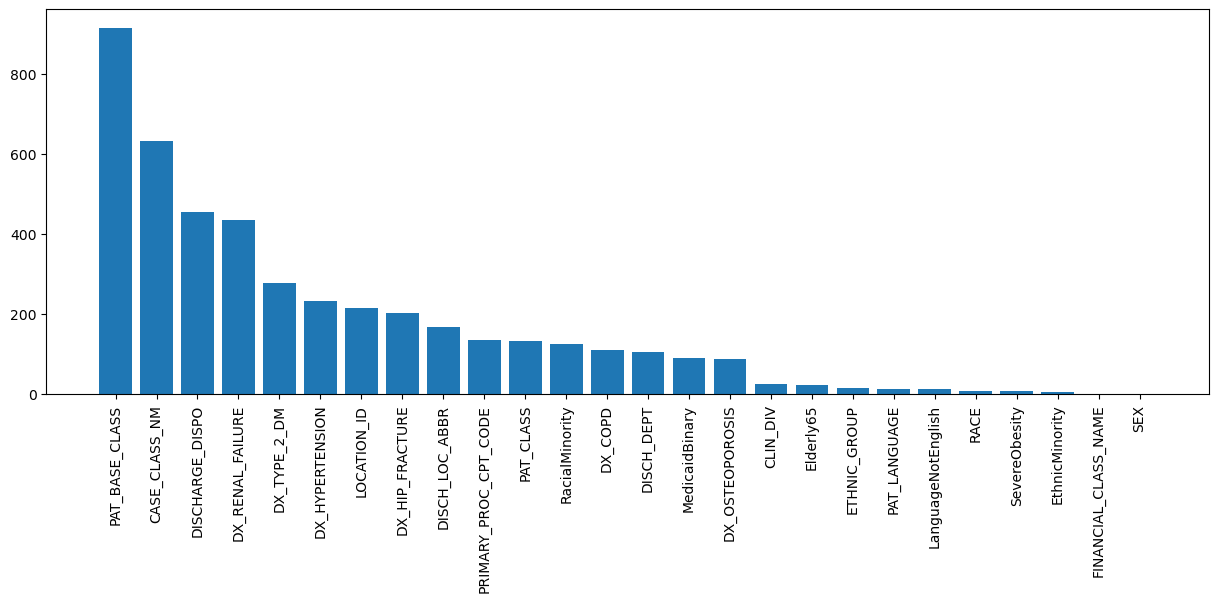

,Feature,Score
1,PAT_BASE_CLASS,916.247681
16,CASE_CLASS_NM,633.053223
15,DISCHARGE_DISPO,456.976868
7,DX_RENAL_FAILURE,436.428192
9,DX_TYPE_2_DM,278.222504
6,DX_HYPERTENSION,232.539749
17,LOCATION_ID,214.921478
10,DX_HIP_FRACTURE,202.450104
13,DISCH_LOC_ABBR,168.006760
19,PRIMARY_PROC_CPT_CODE,135.861938


In [21]:
#list of caragorical and numerical variables 
cat_vars = ['PAT_CLASS', 'PAT_BASE_CLASS', 'SEX', 'RACE', 'ETHNIC_GROUP', 
            'PAT_LANGUAGE', 'DX_HYPERTENSION', 'DX_RENAL_FAILURE', 'DX_COPD', 'DX_TYPE_2_DM', 
            'DX_HIP_FRACTURE', 'DX_OSTEOPOROSIS', 'FINANCIAL_CLASS_NAME', 
            'DISCH_LOC_ABBR','DISCH_DEPT', 'DISCHARGE_DISPO', 'CASE_CLASS_NM', 'LOCATION_ID', 
            'CLIN_DIV', 'PRIMARY_PROC_CPT_CODE', 'MedicaidBinary', 'SevereObesity', 
            'Elderly65', 'RacialMinority', 'EthnicMinority', 'LanguageNotEnglish']

#get cat scores
cat_scores = cat_feature_selection(X_train[cat_vars],y_train)

# Plot cat_scores
plt.figure(figsize=(15,5))
plt.bar(x=cat_scores['Feature'], height =cat_scores['Score'])
plt.xticks(rotation=90)
plt.show()

cat_scores



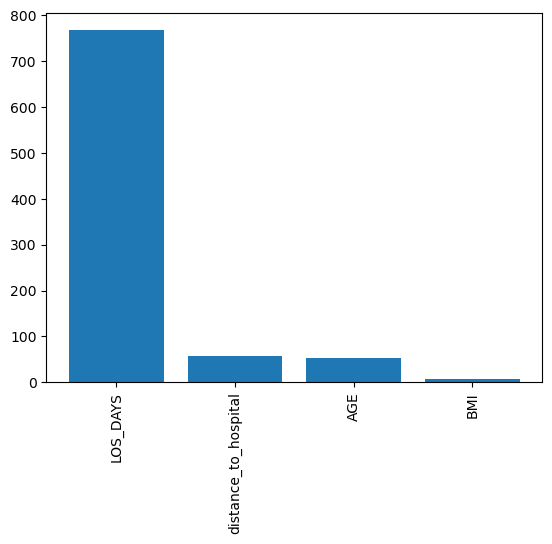

,Feature,Score
1,LOS_DAYS,767.180186
3,distance_to_hospital,57.851120
2,AGE,51.966554
0,BMI,7.238564


In [22]:
#list of numerical features 
cont_vars = ['BMI', 'LOS_DAYS', 'AGE', 'distance_to_hospital']

#univariate methods on continuous variables
cont_scores = cont_feat_selection(X_train[cont_vars],y_train)

# Plot scores
plt.bar(x=cont_scores['Feature'],height=cont_scores['Score'])
plt.xticks(rotation=90)
plt.show()
cont_scores

In [23]:
#function to drop cols
def drop_cols(X_train, X_test, cols_drop):
    '''
    Drops the features selected to drop from the training and test sets

    Inputs:
        X_train(pd.DataFrame): training set inputs
        X_test(pd.DataFrame): test set inputs
        feats_to_drop(list): list of features to drop

    Returns:
        X_train(pd.DataFrame): training set inputs with the features dropped
        X_test(pd.DataFrame): test set inputs with the features dropped


    '''
    
    X_train = X_train.drop(labels=cols_drop,axis=1)
    X_test = X_test.drop(labels=cols_drop,axis=1)

    return X_train,X_test

#list of all columns to drop
cols_drop = ['PAT_CLASS', 'BMI', 'PAT_LANGUAGE', 'ETHNIC_GROUP', 'FINANCIAL_CLASS_NAME', 
             'RACE', 'ZIP_5', 'DISCH_DEPT', 'LOCATION_ID', 'ZIP_5',
             'WhiteNonHipanic', 'Race_OtherAsian', 'Race_Other', 'Race_NotReported', 'Race_NativeHawaiian',
             'Race_White', 'Race_Black', 'Race_Asian', 'Race_AmericanIndian', 'Race_NotValid', 
             'Hispanic_7', 'Hispanic_NotHispanic', 'Hispanic_5', 'Hispanic_4', 'Hispanic_3', 
             'Hispanic_2', 'Hispanic_1', 'RaceDummy_5', 'RaceDummy_4', 'FinancialClass_Commercial',
             'FinancialClass_Liability', 'FinancialClass_ManagedCare','FinancialClass_MedicaidPending', 
             'FinancialClass_MediCARE','FinancialClass_MedicareAdvantage','FinancialClass_CommercialBlueCross', 
             'FinancialClass_MedicaidNC','FinancialClass_MedicaidManaged', 'FinancialClass_CommercialBCOOS',
            'FinancialClass_Medcaid', 'FinancialClass_12Unkonwn','FinancialClass_13', 'FinancialClass_14', 
            'FinancialClass_15','FinancialClass_WorkersComp', 'Sex_Female', 'Sex_2', 'Sex_3', 'PRIMARY_PROC_CPT_CODE']

X_train, X_test = drop_cols(X_train, X_test, cols_drop)
X_train.info()
X_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21145 entries, 961 to 16941
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PAT_BASE_CLASS        21145 non-null  object 
 1   AGE                   21145 non-null  float64
 2   SEX                   21145 non-null  object 
 3   DX_HYPERTENSION       21145 non-null  float64
 4   DX_RENAL_FAILURE      21145 non-null  float64
 5   DX_COPD               21145 non-null  float64
 6   DX_TYPE_2_DM          21145 non-null  float64
 7   DX_HIP_FRACTURE       21145 non-null  float64
 8   DX_OSTEOPOROSIS       21145 non-null  float64
 9   DISCH_LOC_ABBR        21145 non-null  object 
 10  LOS_DAYS              21145 non-null  float64
 11  DISCHARGE_DISPO       21145 non-null  object 
 12  CASE_CLASS_NM         21145 non-null  object 
 13  CLIN_DIV              21145 non-null  object 
 14  MedicaidBinary        21145 non-null  float64
 15  SevereObesity    

,PAT_BASE_CLASS,AGE,SEX,DX_HYPERTENSION,DX_RENAL_FAILURE,DX_COPD,DX_TYPE_2_DM,DX_HIP_FRACTURE,DX_OSTEOPOROSIS,DISCH_LOC_ABBR,LOS_DAYS,DISCHARGE_DISPO,CASE_CLASS_NM,CLIN_DIV,MedicaidBinary,SevereObesity,Elderly65,STATE,distance_to_hospital,RacialMinority,EthnicMinority,LanguageNotEnglish
961,Outpatient,15.0,Male,0.0,0.0,0.0,0.0,0.0,0.0,AASC,0.3,Home or Self Care,Elective,SPORTS MED,0.0,0.0,0.0,NC,14.374165,0,0,0
24031,Outpatient,58.0,Female,0.0,0.0,0.0,0.0,0.0,0.0,DRH,1.2,Home or Self Care,Elective,HIP PRESERVATION,0.0,1.0,0.0,NC,61.969487,0,0,0
24517,Inpatient,15.0,Female,0.0,1.0,0.0,0.0,0.0,0.0,DUH,7.9,Home or Self Care,Elective,ONCOLOGY,0.0,0.0,0.0,NC,109.377692,0,0,0
4480,Outpatient,28.0,Female,0.0,0.0,0.0,0.0,0.0,0.0,DRAH,0.3,Home or Self Care,Elective,SPORTS MED,0.0,0.0,0.0,NC,30.210394,0,0,0
21404,Outpatient,59.0,Female,1.0,0.0,0.0,0.0,0.0,0.0,DRAH,0.2,Home or Self Care,Elective,HAND,0.0,0.0,0.0,NC,52.258676,0,0,0


In [24]:
def encode_training_set(X,onehot_cols):
    '''
    Encodes the training set categorical features using ordinal and one-hot encoding

    Inputs:
        X(pd.DataFrame): training set inputs
        onehot_cols(list): list of features to one-hot encode

    Returns:
        X(pd.DataFrame): training set inputs with the features encoded
        onehot_enc(sklearn.preprocessing.OneHotEncoder): one-hot encoder fit on the training data
    '''

    # Encode categorical variables
    onehot_enc = OneHotEncoder(handle_unknown='ignore')
    # Fit encoder on training data
    onehot_enc.fit(X[onehot_cols])
    # Get the names of the new columns created
    colnames = columns=list(onehot_enc.get_feature_names_out(input_features=onehot_cols))
    # Transform the data
    onehot_vals = onehot_enc.transform(X[onehot_cols]).toarray()
    # Put transformed data into dataframe.  Make sure index matches
    enc_df = pd.DataFrame(onehot_vals,columns=colnames,index=X.index)
    # Add onehot columns back onto original dataframe and drop the original columns
    X = pd.concat([X,enc_df],axis=1).drop(onehot_cols,axis=1)

    return X,onehot_enc

In [25]:
# Test cell for encode_training_set() (this may take a minute to run)
X_train_encoded = X_train.copy()

#cols to encode 
cols_onehot = ['SEX', 'DISCH_LOC_ABBR', 'DISCHARGE_DISPO', 'CASE_CLASS_NM', 'CLIN_DIV', 'PAT_BASE_CLASS', 'STATE']
#Make sure all categorical columns are string type
for col in cols_onehot:
    X_train_encoded[col] = X_train_encoded[col].astype(str)

X_train_encoded, onehot_encoder = encode_training_set(X_train_encoded,cols_onehot)
display(X_train_encoded.head())

,AGE,DX_HYPERTENSION,DX_RENAL_FAILURE,DX_COPD,DX_TYPE_2_DM,DX_HIP_FRACTURE,DX_OSTEOPOROSIS,LOS_DAYS,MedicaidBinary,SevereObesity,Elderly65,distance_to_hospital,RacialMinority,EthnicMinority,LanguageNotEnglish,SEX_Female,SEX_Male,SEX_Unknown,DISCH_LOC_ABBR_AASC,DISCH_LOC_ABBR_DASC,DISCH_LOC_ABBR_DRAH,DISCH_LOC_ABBR_DRH,DISCH_LOC_ABBR_DUH,DISCHARGE_DISPO_Court/Law Enforcement,DISCHARGE_DISPO_Home Health Service,DISCHARGE_DISPO_Home or Self Care,DISCHARGE_DISPO_Hospice (Home),DISCHARGE_DISPO_Hospice Medical Inpatient,DISCHARGE_DISPO_Intermediate Care Facility,DISCHARGE_DISPO_Long Term Acute Care (LTAC),DISCHARGE_DISPO_Not Listed,DISCHARGE_DISPO_OTH INST W PLANNED READM,DISCHARGE_DISPO_Other Healthcare Institution,DISCHARGE_DISPO_Psych Facility,DISCHARGE_DISPO_Rehab Facility,DISCHARGE_DISPO_Skilled Nursing Facility,CASE_CLASS_NM_Elective,CASE_CLASS_NM_Level 1,CASE_CLASS_NM_Level 2,CASE_CLASS_NM_Level 3,CASE_CLASS_NM_Level 4,CASE_CLASS_NM_Level 5,CASE_CLASS_NM_OB Urgent,CLIN_DIV_FOOT & ANKLE,CLIN_DIV_HAND,CLIN_DIV_HIP PRESERVATION,CLIN_DIV_ONCOLOGY,CLIN_DIV_PEDIATRIC,CLIN_DIV_PEDIATRIC - Chair,CLIN_DIV_SPINE,CLIN_DIV_SPORTS MED,CLIN_DIV_TOTAL JOINT,CLIN_DIV_TRAUMA,PAT_BASE_CLASS_Emergency,PAT_BASE_CLASS_Inpatient,PAT_BASE_CLASS_Outpatient,STATE_AK,STATE_AL,STATE_AR,STATE_AZ,STATE_CA,STATE_CO,STATE_CT,STATE_DC,STATE_DE,STATE_FL,STATE_GA,STATE_IA,STATE_IL,STATE_IN,STATE_KS,STATE_KY,STATE_LA,STATE_MA,STATE_MD,STATE_ME,STATE_MI,STATE_MN,STATE_MO,STATE_MS,STATE_NC,STATE_NE,STATE_NH,STATE_NJ,STATE_NM,STATE_NY,STATE_OH,STATE_OR,STATE_PA,STATE_RI,STATE_SC,STATE_SD,STATE_TN,STATE_TX,STATE_UT,STATE_VA,STATE_WA,STATE_WI,STATE_WV,STATE_WY
961,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0,14.374165,0,0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24031,58.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2,0.0,1.0,0.0,61.969487,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24517,15.0,0.0,1.0,0.0,0.0,0.0,0.0,7.9,0.0,0.0,0.0,109.377692,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4480,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0,30.210394,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21404,59.0,1.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,52.258676,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
def encode_test_set(X,onehot_cols,onehot_enc):
    '''
    Encodes the categorical features of the test set

    Inputs:
        X(pd.DataFrame): test set inputs
        onehot_cols(list): list of features to one-hot encode
        onehot_enc(sklearn.preprocessing.OneHotEncoder): one-hot encoder fit on the training data

    Returns:
        X(pd.DataFrame): test set inputs with features encoded
    '''
    ### BEGIN SOLUTION ###
    # Onehot encode columns
    colnames = columns=list(onehot_enc.get_feature_names_out(input_features=onehot_cols))
    onehot_vals = onehot_enc.transform(X[onehot_cols]).toarray()
    # Put transformed data into dataframe
    enc_df = pd.DataFrame(onehot_vals,columns=colnames,index=X.index)
    # Add onehot columns back onto original dataframe and drop the original columns
    X = pd.concat([X,enc_df],axis=1).drop(onehot_cols,axis=1)
    return X


In [27]:
# Test cell for encode_test_set()
X_test_encoded = X_test.copy()

# Make sure all categorical columns are string type
for col in cols_onehot:
    X_test_encoded[col] = X_test_encoded[col].astype(str)

X_test_encoded = encode_test_set(X_test_encoded,cols_onehot, onehot_encoder)

In [28]:
display(X_train_encoded.head())
display(X_test_encoded.head())
display(y_train)

display(y_test)

,AGE,DX_HYPERTENSION,DX_RENAL_FAILURE,DX_COPD,DX_TYPE_2_DM,DX_HIP_FRACTURE,DX_OSTEOPOROSIS,LOS_DAYS,MedicaidBinary,SevereObesity,Elderly65,distance_to_hospital,RacialMinority,EthnicMinority,LanguageNotEnglish,SEX_Female,SEX_Male,SEX_Unknown,DISCH_LOC_ABBR_AASC,DISCH_LOC_ABBR_DASC,DISCH_LOC_ABBR_DRAH,DISCH_LOC_ABBR_DRH,DISCH_LOC_ABBR_DUH,DISCHARGE_DISPO_Court/Law Enforcement,DISCHARGE_DISPO_Home Health Service,DISCHARGE_DISPO_Home or Self Care,DISCHARGE_DISPO_Hospice (Home),DISCHARGE_DISPO_Hospice Medical Inpatient,DISCHARGE_DISPO_Intermediate Care Facility,DISCHARGE_DISPO_Long Term Acute Care (LTAC),DISCHARGE_DISPO_Not Listed,DISCHARGE_DISPO_OTH INST W PLANNED READM,DISCHARGE_DISPO_Other Healthcare Institution,DISCHARGE_DISPO_Psych Facility,DISCHARGE_DISPO_Rehab Facility,DISCHARGE_DISPO_Skilled Nursing Facility,CASE_CLASS_NM_Elective,CASE_CLASS_NM_Level 1,CASE_CLASS_NM_Level 2,CASE_CLASS_NM_Level 3,CASE_CLASS_NM_Level 4,CASE_CLASS_NM_Level 5,CASE_CLASS_NM_OB Urgent,CLIN_DIV_FOOT & ANKLE,CLIN_DIV_HAND,CLIN_DIV_HIP PRESERVATION,CLIN_DIV_ONCOLOGY,CLIN_DIV_PEDIATRIC,CLIN_DIV_PEDIATRIC - Chair,CLIN_DIV_SPINE,CLIN_DIV_SPORTS MED,CLIN_DIV_TOTAL JOINT,CLIN_DIV_TRAUMA,PAT_BASE_CLASS_Emergency,PAT_BASE_CLASS_Inpatient,PAT_BASE_CLASS_Outpatient,STATE_AK,STATE_AL,STATE_AR,STATE_AZ,STATE_CA,STATE_CO,STATE_CT,STATE_DC,STATE_DE,STATE_FL,STATE_GA,STATE_IA,STATE_IL,STATE_IN,STATE_KS,STATE_KY,STATE_LA,STATE_MA,STATE_MD,STATE_ME,STATE_MI,STATE_MN,STATE_MO,STATE_MS,STATE_NC,STATE_NE,STATE_NH,STATE_NJ,STATE_NM,STATE_NY,STATE_OH,STATE_OR,STATE_PA,STATE_RI,STATE_SC,STATE_SD,STATE_TN,STATE_TX,STATE_UT,STATE_VA,STATE_WA,STATE_WI,STATE_WV,STATE_WY
961,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0,14.374165,0,0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24031,58.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2,0.0,1.0,0.0,61.969487,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24517,15.0,0.0,1.0,0.0,0.0,0.0,0.0,7.9,0.0,0.0,0.0,109.377692,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4480,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0,30.210394,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21404,59.0,1.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,52.258676,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,AGE,DX_HYPERTENSION,DX_RENAL_FAILURE,DX_COPD,DX_TYPE_2_DM,DX_HIP_FRACTURE,DX_OSTEOPOROSIS,LOS_DAYS,MedicaidBinary,SevereObesity,Elderly65,distance_to_hospital,RacialMinority,EthnicMinority,LanguageNotEnglish,SEX_Female,SEX_Male,SEX_Unknown,DISCH_LOC_ABBR_AASC,DISCH_LOC_ABBR_DASC,DISCH_LOC_ABBR_DRAH,DISCH_LOC_ABBR_DRH,DISCH_LOC_ABBR_DUH,DISCHARGE_DISPO_Court/Law Enforcement,DISCHARGE_DISPO_Home Health Service,DISCHARGE_DISPO_Home or Self Care,DISCHARGE_DISPO_Hospice (Home),DISCHARGE_DISPO_Hospice Medical Inpatient,DISCHARGE_DISPO_Intermediate Care Facility,DISCHARGE_DISPO_Long Term Acute Care (LTAC),DISCHARGE_DISPO_Not Listed,DISCHARGE_DISPO_OTH INST W PLANNED READM,DISCHARGE_DISPO_Other Healthcare Institution,DISCHARGE_DISPO_Psych Facility,DISCHARGE_DISPO_Rehab Facility,DISCHARGE_DISPO_Skilled Nursing Facility,CASE_CLASS_NM_Elective,CASE_CLASS_NM_Level 1,CASE_CLASS_NM_Level 2,CASE_CLASS_NM_Level 3,CASE_CLASS_NM_Level 4,CASE_CLASS_NM_Level 5,CASE_CLASS_NM_OB Urgent,CLIN_DIV_FOOT & ANKLE,CLIN_DIV_HAND,CLIN_DIV_HIP PRESERVATION,CLIN_DIV_ONCOLOGY,CLIN_DIV_PEDIATRIC,CLIN_DIV_PEDIATRIC - Chair,CLIN_DIV_SPINE,CLIN_DIV_SPORTS MED,CLIN_DIV_TOTAL JOINT,CLIN_DIV_TRAUMA,PAT_BASE_CLASS_Emergency,PAT_BASE_CLASS_Inpatient,PAT_BASE_CLASS_Outpatient,STATE_AK,STATE_AL,STATE_AR,STATE_AZ,STATE_CA,STATE_CO,STATE_CT,STATE_DC,STATE_DE,STATE_FL,STATE_GA,STATE_IA,STATE_IL,STATE_IN,STATE_KS,STATE_KY,STATE_LA,STATE_MA,STATE_MD,STATE_ME,STATE_MI,STATE_MN,STATE_MO,STATE_MS,STATE_NC,STATE_NE,STATE_NH,STATE_NJ,STATE_NM,STATE_NY,STATE_OH,STATE_OR,STATE_PA,STATE_RI,STATE_SC,STATE_SD,STATE_TN,STATE_TX,STATE_UT,STATE_VA,STATE_WA,STATE_WI,STATE_WV,STATE_WY
24911,65.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,148.143230,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3280,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,62.463673,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20429,82.0,1.0,0.0,0.0,1.0,0.0,0.0,0.4,0.0,0.0,1.0,141.423479,0,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6714,78.0,1.0,0.0,0.0,0.0,0.0,0.0,10.4,0.0,0.0,1.0,62.247531,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4120,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.3,0.0,0.0,0.0,53.594682,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


array([0., 0., 0., ..., 0., 0., 0.])

array([1., 0., 0., ..., 0., 0., 0.])

# Part III - Model Building and Tuning
- ### We will start by splitting our data into training/validation
- ### next we will build a random forest with default hyperparamaters
- ### Next we will try smaller subsets of features based on feature importance and see if we can retain performance 
    - #### remember for a clinical prediciton model such as this one interpretability is vital so we want to simplify our feature set as much as possible
- ### finally we will tune and train an optimal model 

In [29]:
def split_validation(X_train, y_train): 
    ''''
    Splits training set into training/validation for model tuning and optimization 

    Inputs: X_train (pd.DataFrame), y_train (pd.DataFrame)
    Outputs: X_train_val (pd.DataFrame), X_test_val (pd.DataFrame), y_train_val(pd.DataFrame), y_test_val(pd.DataFrame)

    '''

    #spits into sub sets of training and validation 
    X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train,y_train, stratify = y_train, random_state=0,test_size=0.20)
    
    return X_train_val, X_test_val, y_train_val, y_test_val 



In [30]:
X_train_val, X_test_val, y_train_val, y_test_val = split_validation(X_train_encoded, y_train)

In [31]:
#now that we've finished encoding we will use RF feature importance to further refine our feature set
def feature_importance(X_train_val,y_train_val, X_test_val, y_test_val): 
    ''' 
    Trains a random forest on the training set and predicts on the validation set. Plots RF feature importance, classification report and AUROC. 
    It also further splits training sets into train/validation sets for future tunin 

    Inputs: X_train (pd.DataFrame), y_train (pd.DataFrame)
    Outputs: RF_Ranking (pd.DataFrame), X_train_val (pd.DataFrame), X_test_val (pd.DataFrame), y_train_val (pd.DataFrame), y_test_val (pd.DataFrame)

    '''

    #we will start off using the default scikit learn features 
    rf_model = RandomForestClassifier(criterion='gini',max_depth=None, min_samples_leaf=1,n_estimators=100,
                                 max_features='sqrt',max_samples=None,random_state=0)
    
    # Fit the tree to the data
    rf_model.fit(X_train_val, y_train_val)

    #predict on the validation set
    val_preds = rf_model.predict(X_test_val)

    #define feature names 
    feat_names = X_train_val.columns 

    #define the number of features to show
    num_to_show = 55 

    # Determine the relative importance of each feature using the random forest model
    importances = rf_model.feature_importances_

    # Get an array of the indices that would sort "importances" in reverse order to get largest to smallest
    indices = np.argsort(importances)[::-1]
    ranked_feats = []
    for i in range(len(indices)):
        feat_name = feat_names[indices[i]]
        ranked_feats.append(feat_name)
    RF_ranking = pd.DataFrame()
    RF_ranking['Feat Index'] = indices
    RF_ranking['Feature'] = ranked_feats
    RF_ranking['Importance'] = np.sort(importances)[::-1]
    display(RF_ranking.iloc[:num_to_show,:])

    # Plot the importance value for each feature
    RF_ranking[:30][::-1].plot(x='Feature',y='Importance',kind='barh',figsize=(12,7),legend=False,title='RF Feature Importance')
    plt.show()

    print(f'the classification report for RF on validation set is\n {classification_report(y_test_val, val_preds)}')
    #display AUROC of model performance on only minority patients
    plot_roc_curve(rf_model,X_test_val,y_test_val)
    # Add a line to show the curve for random guessing
    plt.plot([0,1],[0,1],linestyle='--',label='Random guessing')
    plt.legend()
    plt.title('Random Forest Performance on Validation Set')
    plt.show()

    return RF_ranking



,Feat Index,Feature,Importance
0,11,distance_to_hospital,0.206357
1,0,AGE,0.200096
2,7,LOS_DAYS,0.150960
3,9,SevereObesity,0.024775
4,12,RacialMinority,0.024537
5,1,DX_HYPERTENSION,0.020841
6,4,DX_TYPE_2_DM,0.019559
7,15,SEX_Female,0.018317
8,10,Elderly65,0.018212
9,16,SEX_Male,0.017914


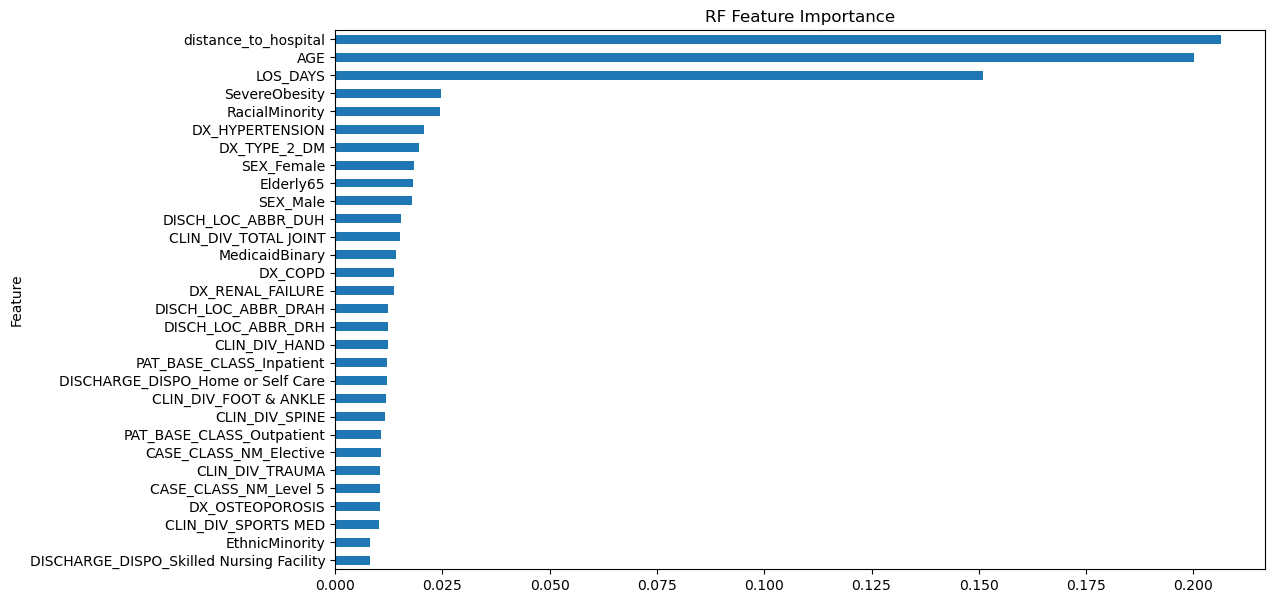

the classification report for RF on validation set is
               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      3903
         1.0       0.40      0.04      0.08       326

    accuracy                           0.92      4229
   macro avg       0.66      0.52      0.52      4229
weighted avg       0.89      0.92      0.89      4229



/Users/brunovalan/opt/anaconda3/envs/AIPI520/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


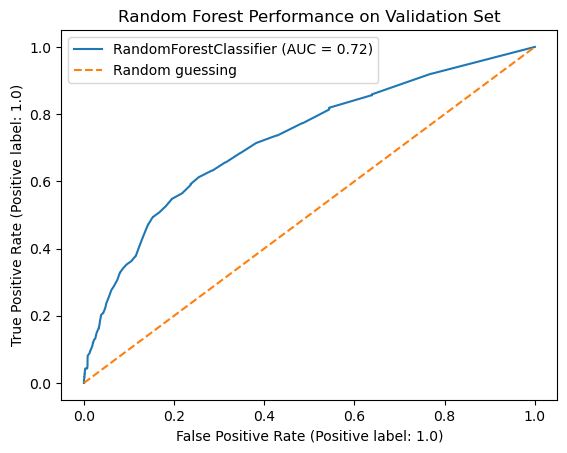

In [32]:
RF_ranking_full = feature_importance(X_train_val,y_train_val, X_test_val, y_test_val)

### Next we will try running the same model with only the top 10, 20 and 50 features to see if we can simplify our feature set

In [33]:
#creates list of features we will use
top_50 = RF_ranking_full['Feature'].iloc[:50].tolist()
top_30 = RF_ranking_full['Feature'].iloc[:30].tolist()
top_20 = RF_ranking_full['Feature'].iloc[:20].tolist()
top_10 = RF_ranking_full['Feature'].iloc[:10].tolist()


In [34]:
for feat in top_20: 
    print(feat)

distance_to_hospital
AGE
LOS_DAYS
SevereObesity
RacialMinority
DX_HYPERTENSION
DX_TYPE_2_DM
SEX_Female
Elderly65
SEX_Male
DISCH_LOC_ABBR_DUH
CLIN_DIV_TOTAL JOINT
MedicaidBinary
DX_COPD
DX_RENAL_FAILURE
DISCH_LOC_ABBR_DRAH
DISCH_LOC_ABBR_DRH
CLIN_DIV_HAND
PAT_BASE_CLASS_Inpatient
DISCHARGE_DISPO_Home or Self Care


In [35]:
def RF_limited_features(X_train_val, y_train_val, X_test_val, y_test_val, top_feats):
    '''
    Takes training and validation sets with specified number of top features to use, 
    trains random forest and prints RF top features, classification report and AUROC 

    Inputs: X_train_val (pd.DataFrame), y_train_val (np.array), X_test_val (pd.DataFrame), y_test_val (np.array), top_feats (list)
    Outputs: RF_ranking (pd.DataFrame)
    
    '''

    #filter the top features on the training set 
    X_train_val = X_train_val[top_feats]

    #filter the top features on the test set
    X_test_val = X_test_val[top_feats]

    #we will start off using the default scikit learn features 
    rf_model_limited = RandomForestClassifier(criterion='gini',max_depth=None, min_samples_leaf=1,n_estimators=100,
                                 max_features='sqrt',max_samples=None,random_state=0)

    # Fit the tree to the data
    rf_model_limited.fit(X_train_val, y_train_val)

    #predict on the validation set
    val_preds = rf_model_limited.predict(X_test_val)

    #define feature names 
    feat_names = X_train_val.columns 

    #define the number of features to show
    num_to_show = len(top_feats)

    # Determine the relative importance of each feature using the random forest model
    importances = rf_model_limited.feature_importances_

    # Get an array of the indices that would sort "importances" in reverse order to get largest to smallest
    indices = np.argsort(importances)[::-1]
    ranked_feats = []
    for i in range(len(indices)):
        feat_name = feat_names[indices[i]]
        ranked_feats.append(feat_name)
    RF_ranking = pd.DataFrame()
    RF_ranking['Feat Index'] = indices
    RF_ranking['Feature'] = ranked_feats
    RF_ranking['Importance'] = np.sort(importances)[::-1]
    display(RF_ranking.iloc[:num_to_show,:])

    # Plot the importance value for each feature
    RF_ranking[:30][::-1].plot(x='Feature',y='Importance',kind='barh',figsize=(12,7),legend=False,title='RF Feature Importance')
    plt.show()

    #try adjusting threhold 
    y_pred_proba = rf_model_limited.predict_proba(X_test_val)[:, 1] # get predicted probabilities for positive class only
    y_pred_custom = (y_pred_proba >= 0.2).astype(int)

    # prints the classification report for the RF on the limited feature set 
    print(f'the classification report for RF on validation set is\n {classification_report(y_test_val, y_pred_custom)}')

    #display AUROC of model performance on only minority patients
    plot_roc_curve(rf_model_limited,X_test_val,y_test_val)
    # Add a line to show the curve for random guessing
    plt.plot([0,1],[0,1],linestyle='--',label='Random guessing')
    plt.legend()
    plt.title('Random Forest Performance on Validation Set')
    plt.show()
   

    return RF_ranking

,Feat Index,Feature,Importance
0,0,distance_to_hospital,0.319193
1,1,AGE,0.299451
2,2,LOS_DAYS,0.266784
3,3,SevereObesity,0.020691
4,4,RacialMinority,0.019528
5,5,DX_HYPERTENSION,0.018268
6,6,DX_TYPE_2_DM,0.017455
7,9,SEX_Male,0.013222
8,7,SEX_Female,0.012940
9,8,Elderly65,0.012467


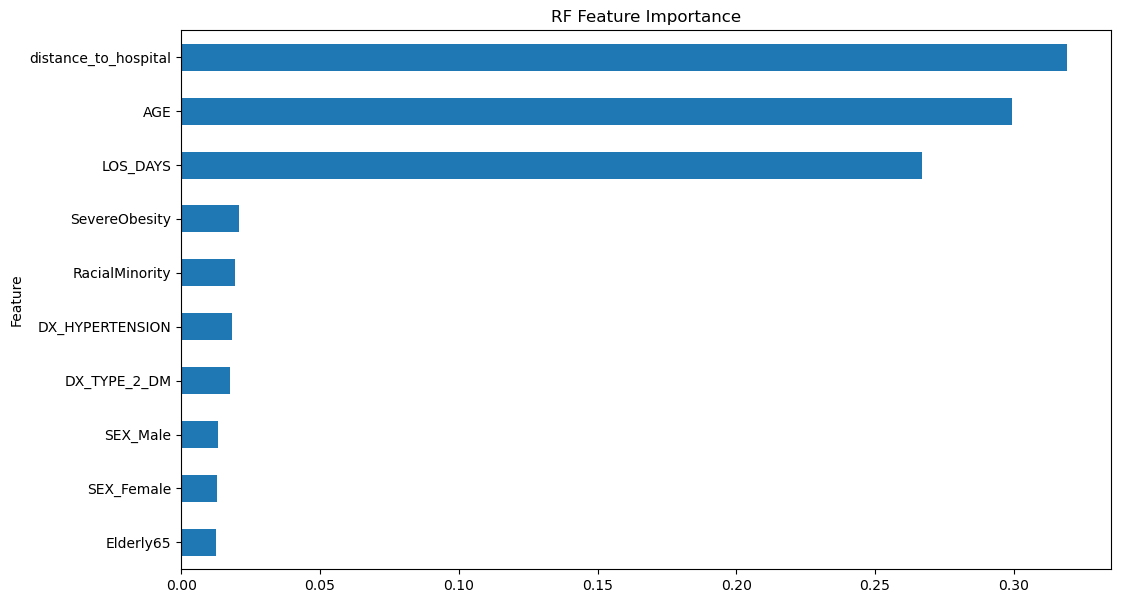

the classification report for RF on validation set is
               precision    recall  f1-score   support

         0.0       0.94      0.89      0.92      3903
         1.0       0.22      0.37      0.27       326

    accuracy                           0.85      4229
   macro avg       0.58      0.63      0.59      4229
weighted avg       0.89      0.85      0.87      4229



/Users/brunovalan/opt/anaconda3/envs/AIPI520/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


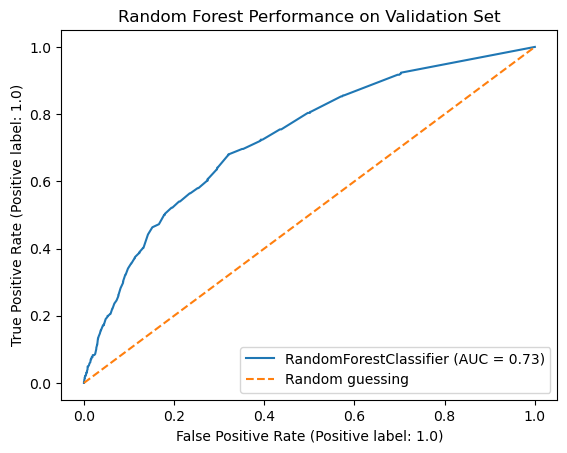

In [36]:
RF_ranking_top10 = RF_limited_features(X_train_val, y_train_val, X_test_val, y_test_val, top_10)

,Feat Index,Feature,Importance
0,0,distance_to_hospital,0.252416
1,1,AGE,0.239831
2,2,LOS_DAYS,0.191301
3,3,SevereObesity,0.025785
4,11,CLIN_DIV_TOTAL JOINT,0.023729
5,18,PAT_BASE_CLASS_Inpatient,0.022780
6,4,RacialMinority,0.022166
7,5,DX_HYPERTENSION,0.021461
8,6,DX_TYPE_2_DM,0.019553
9,17,CLIN_DIV_HAND,0.019355


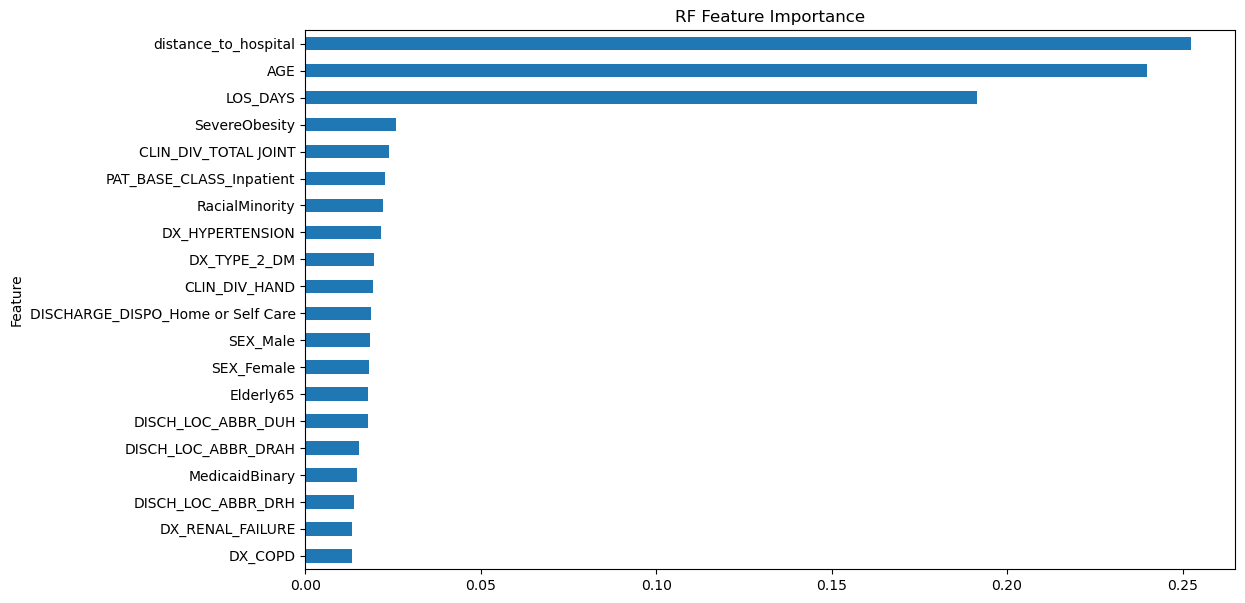

the classification report for RF on validation set is
               precision    recall  f1-score   support

         0.0       0.94      0.89      0.92      3903
         1.0       0.22      0.37      0.28       326

    accuracy                           0.85      4229
   macro avg       0.58      0.63      0.60      4229
weighted avg       0.89      0.85      0.87      4229



/Users/brunovalan/opt/anaconda3/envs/AIPI520/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


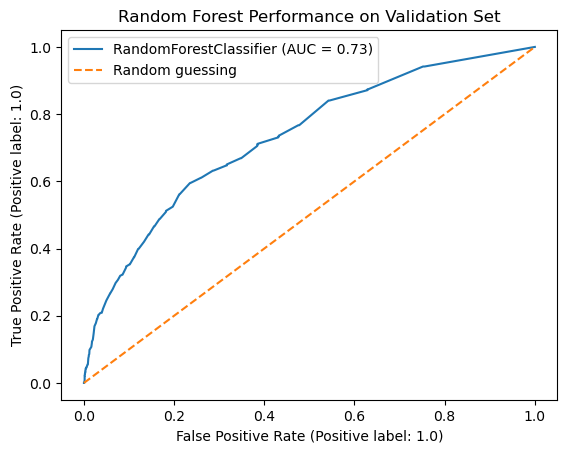

In [37]:
RF_ranking_top20 = RF_limited_features(X_train_val, y_train_val, X_test_val, y_test_val, top_20)

### Based on the above results we can see that our best performance was with only 20 features, now we will train and tune our model using only the top 20 features and see if we can improve performance
### Deleted grid-search function because it was taking to long, optimal paramaters below

{'max_features': 0.1,
 'max_samples': 0.3,
 'min_samples_leaf': 1,
 'n_estimators': 1000}

In [38]:
def run_optimized_model(X_train_val, y_train_val, X_test_val, y_test_val, top_20): 

   #define optimal model hyperparameters
   opt_model = RandomForestClassifier(criterion = 'gini', max_features= 0.1, max_depth = None, 
                                 max_samples= 0.3, min_samples_leaf= 1, n_estimators= 1000, random_state = 0)

   #filter training set for top 20 features 
   X_train_val = X_train_val[top_20]

   #filter test set for top 20 features
   X_test_val = X_test_val[top_20]

   #fit optimal model
   opt_model.fit(X_train_val, y_train_val)
   
   #predict optimal model
   opt_preds = opt_model.predict(X_test_val)

   #get probability from the model
   predict_proba = opt_model.predict_proba(X_test_val)[:, 1]

   #change prediction threshold 0.3 
   preds_custom = (predict_proba >= .03).astype(int)

   #prints the classification report for the RF on the limited feature set with prediction threshold = 0.3
   print(f'the classification report for the optimal RF on validation set is\n {classification_report(y_test_val, preds_custom)}')
   
   #prints the classification retport for the RF on the limited featured set with prediction threshold = 0.3
   print(f'the classification report for the optimal RF on validation set is\n {classification_report(y_test_val, opt_preds)}')

   return opt_model, opt_preds, preds_custom 


the classification report for the optimal RF on validation set is
               precision    recall  f1-score   support

         0.0       0.98      0.39      0.56      3903
         1.0       0.11      0.88      0.19       326

    accuracy                           0.43      4229
   macro avg       0.54      0.64      0.38      4229
weighted avg       0.91      0.43      0.53      4229

the classification report for the optimal RF on validation set is
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      3903
         1.0       0.75      0.01      0.02       326

    accuracy                           0.92      4229
   macro avg       0.84      0.50      0.49      4229
weighted avg       0.91      0.92      0.89      4229



/Users/brunovalan/opt/anaconda3/envs/AIPI520/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


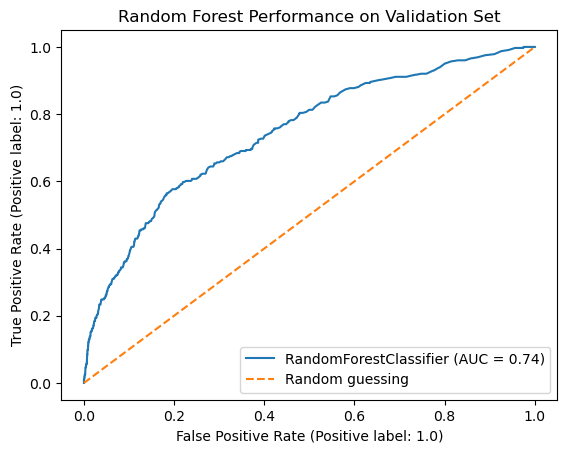

In [39]:
#get final preds with optimized model
opt_model, opt_preds, preds_custom = run_optimized_model(X_train_val, y_train_val, X_test_val, y_test_val, top_20)

#display AUROC of model performance
plot_roc_curve(opt_model,X_test_val[top_20],y_test_val)

# Add a line to show the curve for random guessing
plt.plot([0,1],[0,1],linestyle='--',label='Random guessing')
plt.legend()
plt.title('Random Forest Performance on Validation Set')
plt.show()


# Part IV - Final Model Predictions
- ### Now we will make our final model predictions on our test set
- ### we will also see what our most important features were 


In [40]:
def get_rf_predictions(X_train_encoded, X_test_encoded, y_train, y_test, top_20): 

    #filter training and test sets by final feature set
    X_train = X_train_encoded[top_20]
    X_test = X_test_encoded[top_20]

    #define final model
    final_model = RandomForestClassifier(criterion = 'gini', max_features= 0.1, max_depth = None, 
                                 max_samples= 0.3, min_samples_leaf= 1, n_estimators= 1000, random_state = 0)

    #fit model to training & test data
    final_model.fit(X_train,y_train)

    #get final preditions
    final_preds = final_model.predict(X_test)

    #get probability from the model
    predict_proba = final_model.predict_proba(X_test)[:, 1]

    #change prediction threshold 0.3 
    preds_custom = (predict_proba >= 0.2).astype(int)
 
    #prints the classification report for the RF on the limited feature set with prediction threshold = 0.3
    print(f'the classification report for the optimal RF on TEST set (prediction threshold = 0.2) \n {classification_report(y_test, preds_custom)}')
   
    #prints the classification retport for the RF on the limited featured set with prediction threshold = 0.3
    print(f'the classification report for the optimal RF on the TEST set (prediction threshold = 0.5) is\n {classification_report(y_test, final_preds)}')


    return final_model, final_preds, preds_custom

In [51]:
def get_lasso_predictions(X_train_encoded, X_test_encoded, y_train, y_test, top_20): 
    '''
    Trains Lasso regression on the final feature set
    '''

    #filter training and test sets by final feature set
    X_train = X_train_encoded[top_20]
    X_test = X_test_encoded[top_20]

    #define final model
    final_model = LogisticRegression(penalty = 'l1', solver = 'saga', C = .5)

    #fit model to training & test data
    final_model.fit(X_train,y_train)

    #get final preditions
    final_preds = final_model.predict(X_test)

    #get probability from the model
    predict_proba = final_model.predict_proba(X_test)[:, 1]

    #change prediction threshold 0.3 
    preds_custom = (predict_proba >= 0.2).astype(int)
 
    #prints the classification report for the RF on the limited feature set with prediction threshold = 0.3
    print(f'the classification report for the optimal Lasso on TEST set (prediction threshold = 0.2) \n {classification_report(y_test, preds_custom)}')
   
    #prints the classification retport for the RF on the limited featured set with prediction threshold = 0.3
    print(f'the classification report for the optimal Lasso on the TEST set (prediction threshold = 0.5) is\n {classification_report(y_test, final_preds)}')


    return final_model, final_preds, preds_custom

/Users/brunovalan/opt/anaconda3/envs/AIPI520/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/brunovalan/opt/anaconda3/envs/AIPI520/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


the classification report for the optimal Lasso on TEST set (prediction threshold = 0.2) 
               precision    recall  f1-score   support

         0.0       0.93      0.86      0.90      4880
         1.0       0.12      0.23      0.16       407

    accuracy                           0.81      5287
   macro avg       0.53      0.55      0.53      5287
weighted avg       0.87      0.81      0.84      5287

the classification report for the optimal Lasso on the TEST set (prediction threshold = 0.5) is
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      4880
         1.0       0.27      0.01      0.02       407

    accuracy                           0.92      5287
   macro avg       0.60      0.50      0.49      5287
weighted avg       0.87      0.92      0.89      5287



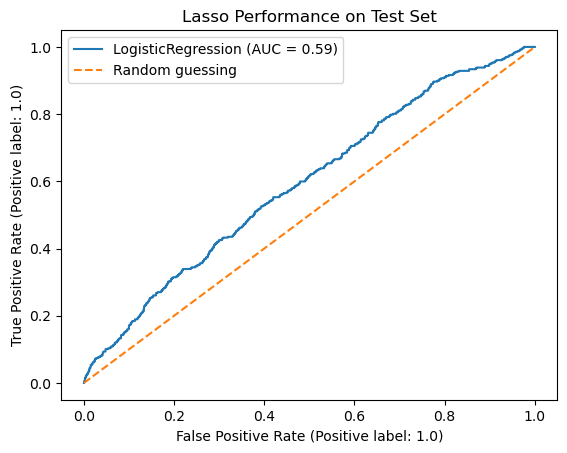

In [52]:
final_lasso_model, final__lasso_preds, lasso_preds_custom = get_lasso_predictions(X_train_encoded, X_test_encoded, y_train, y_test, top_20)

#display AUROC of model performance
plot_roc_curve(final_lasso_model,X_test_encoded[top_20],y_test)

# Add a line to show the curve for random guessing
plt.plot([0,1],[0,1],linestyle='--',label='Random guessing')
plt.legend()
plt.title('Lasso Performance on Test Set')
plt.show()

the classification report for the optimal RF on TEST set (prediction threshold = 0.2) 
               precision    recall  f1-score   support

         0.0       0.95      0.91      0.93      4880
         1.0       0.27      0.38      0.31       407

    accuracy                           0.87      5287
   macro avg       0.61      0.65      0.62      5287
weighted avg       0.89      0.87      0.88      5287

the classification report for the optimal RF on the TEST set (prediction threshold = 0.5) is
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      4880
         1.0       0.50      0.02      0.03       407

    accuracy                           0.92      5287
   macro avg       0.71      0.51      0.50      5287
weighted avg       0.89      0.92      0.89      5287



/Users/brunovalan/opt/anaconda3/envs/AIPI520/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


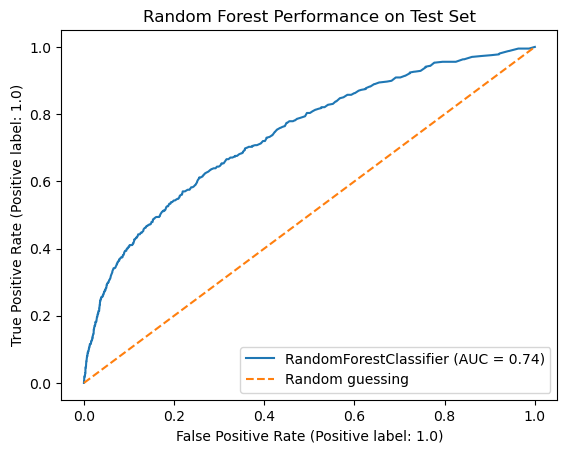

In [46]:
final_model, final_preds, preds_custom = get_rf_predictions(X_train_encoded, X_test_encoded, y_train, y_test, top_20)

#display AUROC of model performance
plot_roc_curve(final_model,X_test_encoded[top_20],y_test)

# Add a line to show the curve for random guessing
plt.plot([0,1],[0,1],linestyle='--',label='Random guessing')
plt.legend()
plt.title('Random Forest Performance on Test Set')
plt.show()

In [43]:
def plot_final_featureimportances(X_train_encoded, top_20, final_model): 
    ''''
    
    
    '''

    #filter training set for top features 
    X_train = X_train_encoded[top_20]

    #define feature names 
    feat_names = X_train.columns 

    #define the number of features to show
    num_to_show = 10

    # Determine the relative importance of each feature using the random forest model
    importances = final_model.feature_importances_

    # Get an array of the indices that would sort "importances" in reverse order to get largest to smallest
    indices = np.argsort(importances)[::-1]
    ranked_feats = []
    for i in range(len(indices)):
        feat_name = feat_names[indices[i]]
        ranked_feats.append(feat_name)
    RF_ranking = pd.DataFrame()
    RF_ranking['Feat Index'] = indices
    RF_ranking['Feature'] = ranked_feats
    RF_ranking['Importance'] = np.sort(importances)[::-1]
    display(RF_ranking.iloc[:num_to_show,:])

    # Plot the importance value for each feature
    RF_ranking[:20][::-1].plot(x='Feature',y='Importance',kind='barh',figsize=(12,7),legend=False,title='RF Feature Importance')
    plt.show()

    return RF_ranking

,Feat Index,Feature,Importance
0,0,distance_to_hospital,0.250454
1,1,AGE,0.237487
2,2,LOS_DAYS,0.195029
3,4,RacialMinority,0.026050
4,18,PAT_BASE_CLASS_Inpatient,0.025699
5,6,DX_TYPE_2_DM,0.024613
6,3,SevereObesity,0.023600
7,11,CLIN_DIV_TOTAL JOINT,0.022923
8,5,DX_HYPERTENSION,0.022645
9,19,DISCHARGE_DISPO_Home or Self Care,0.021662


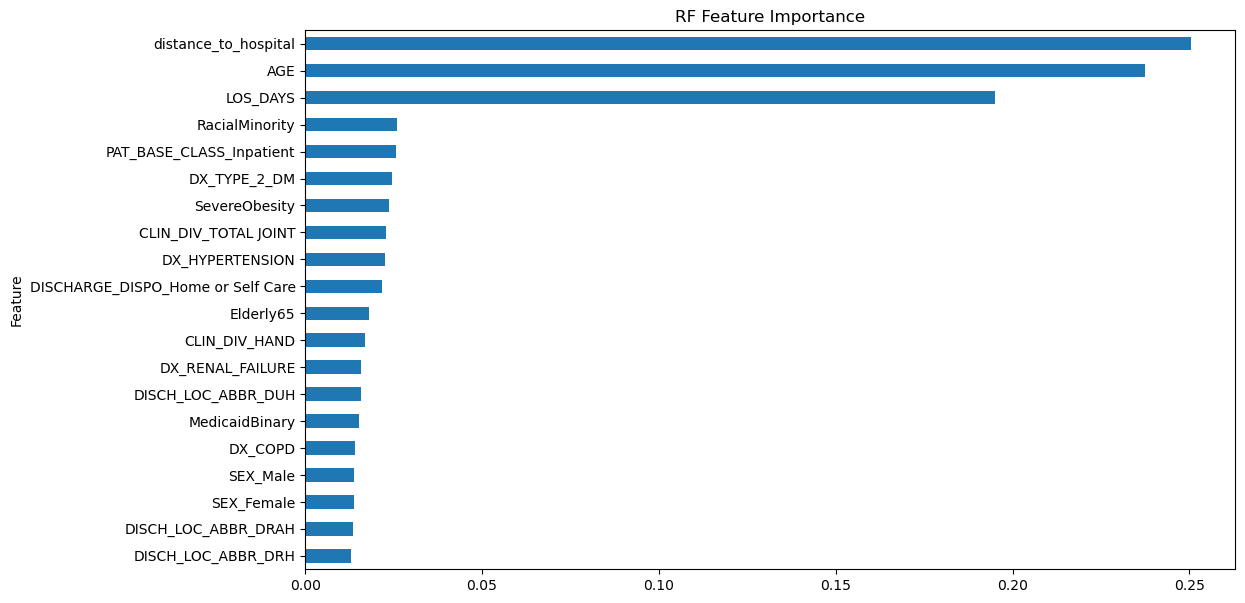

In [44]:
final_feature_importance = plot_final_featureimportances(X_train_encoded, top_20, final_model)